In [1]:
import pandas as pd
import numpy as np

# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

# To Train our data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

import sys
import warnings

warnings.filterwarnings('ignore')

c:\Users\IRONMAN\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP
from models import ML_Models

mlp = MLP()
mlm = ML_Models()

In [3]:
ml_data =  pd.read_csv('../data/facebook_data.csv')

In [4]:
columns_to_be_dropped = ['no','SAID_YES']
ml_data_clean = ml_data.drop(columns_to_be_dropped,axis=1)
ml_data_clean.head(2)

,auction_id,experiment,date,hour,device_make,browser,yes
0,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,Facebook,1
1,023458f7-122d-475f-9525-1b9a3cc7a033,control,2020-07-03,15,MRD-LX1,Facebook,0


In [5]:

cat, num = mlp.sep_cat_num(ml_data_clean)
print("Numerical Columns:", cat)
print("****************")
print("Categorical Columns:", num)

Numerical Columns: ['auction_id', 'experiment', 'date', 'device_make', 'browser']
****************
Categorical Columns: ['hour', 'yes']


In [6]:
ml_data_clean[cat].describe()

,auction_id,experiment,date,device_make,browser
count,156,156,156,156,156
unique,156,2,8,63,1
top,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-03,Samsung SM-G960F,Facebook
freq,1,112,47,16,156


In [7]:
pipe_1 = Pipeline(
    steps=[
        ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": cat})),
        ("scale data", FunctionTransformer(mlp.scaler)),
        ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
        ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
        ])
sets = pipe_1.fit_transform(ml_data_clean)

cat_labeler output...

   auction_id  experiment  date  hour  device_make  browser  yes
0           0           0     5     4           23        0    1
1           1           0     0    15           12        0    0


scaler output... 

   auction_id  experiment      date      hour  device_make  browser  yes
0    0.000000         0.0  0.714286  0.173913     0.370968      0.0  1.0
1    0.006452         0.0  0.000000  0.652174     0.193548      0.0  0.0


target_features output... 

features size: (156, 6)


set_splitter output... 

X_train shape: (114, 6)
y_train shape: (114,)
x_test shape: (16, 6)
y_test shape: (16,)
X_val shape: (26, 6)
y_val shape: (26,)


0.625


Text(0.5, 0, 'Xgboost Feature Importance')

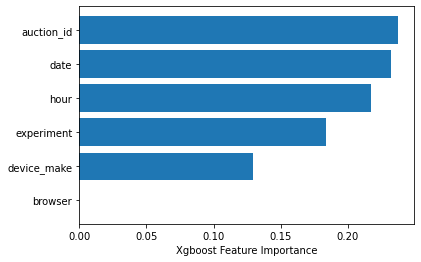

In [12]:
# generate model

model = mlm.xgb_model(sets[0], sets[1], sets[2], sets[3])


# Then predict results from X_test data
pred_xgb = model.predict(sets[2])


accuracy = accuracy_score(pred_xgb, sets[3])
print(accuracy)

#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
sorted_idx = model.feature_importances_.argsort()
columns = np.array(ml_data_clean.columns.to_list()[:6])
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

